# Modelamiento con sitios CpG

## Librerías y path

In [2]:
import sys
from pathlib import Path
import os

src_path = str(Path.cwd().parents[0] / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

raw_path = str(Path.cwd().parents[0] / "data" / "raw")
preprocess_path = str(Path.cwd().parents[0] / "data" / "preprocessed")


In [3]:
import seaborn as sns    
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## Lectura y preprocesamiento básico

In [4]:
df_gdc = pd.read_csv(f'{preprocess_path}/cpg_preprocessed.csv')

In [5]:
# Pasar a años (Posiblemente redundante, por el uso de minmax(?) )
df_gdc['age'] = df_gdc['age']/365.25
# Escalado
df_gdc['age'] = MinMaxScaler().fit_transform(df_gdc[['age']])

In [6]:
features_to_drop = ['file_id', 'size', 'disease', 'race', 'etnia', 'sample_type']
x, y = df_gdc.drop(columns = features_to_drop), df_gdc['sample_type'].replace({'Primary Tumor':1, 'Solid Tissue Normal':0})

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=42)

## Definición de pipelines

Métodos de selección:
- SVM (lineal)
- ANOVA + RF
- RF iterativo

Métodos de clasificación:
- Red feedforward
- RF, XGB
- SVM (RBF)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from imblearn.pipeline import Pipeline
from gene_preprocessing import SelectByIterRF, SelectByPValue
from xgboost import XGBClassifier

In [9]:
anova_fs = [
    ('KBest', SelectPercentile(f_classif, percentile=85)),
    ('P-Value', SelectByPValue()),
    ('Select RF', SelectFromModel(RandomForestClassifier(random_state=42)))
]
sv_fs = [('Select SVM', SelectFromModel(SVC(kernel = 'linear', random_state=42)))]
iter_rf_fs = [('Select RF',SelectByIterRF(thresh=0.99, pos_label=1))]


In [10]:
def fs_pipeline(fs):
    return Pipeline(
        fs
    )

## Clasificación

In [11]:
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from modeling_utils import bar_metrics

basic_estimators = {'SVM': SVC(kernel='rbf', random_state=42),
                      'RF':RandomForestClassifier(random_state=42),
                       'XGB': XGBClassifier(random_state=42)}

In [12]:
def fit_estimators_from_dict(x,  y, basic_estimators):
    '''
        - basic_estimators: diccionario con tipo de estimadores {'clf': clf}
    '''
    fitted_dict = {}
    for estimator in basic_estimators:
        model = clone(basic_estimators[estimator])
        name = type(model).__name__
        fitted_dict[name] = model
        fitted_dict[name].fit(x, y)
        
    return fitted_dict

def predict_from_dict(x, estimators):
    '''
        - estimators: diccionario con estimadores fitteados
    '''
    preds = {}
    for estim in estimators:
        preds[estim] = estimators[estim].predict(x)
    return preds

### Selección con Anova

In [13]:
anova_pipe = fs_pipeline(anova_fs)
anova_pipe.set_output(transform="pandas")
x_anova = anova_pipe.fit_transform(x_train, y_train)
anova_test = anova_pipe.transform(x_test)

x_anova, y_anova = SMOTE().fit_resample(x_anova, y_train)

x_anova.shape

(498, 196)

In [14]:
anova_estimators = fit_estimators_from_dict(x_anova, y_anova, basic_estimators)

In [15]:
anova_pred_test = predict_from_dict(anova_test, anova_estimators)

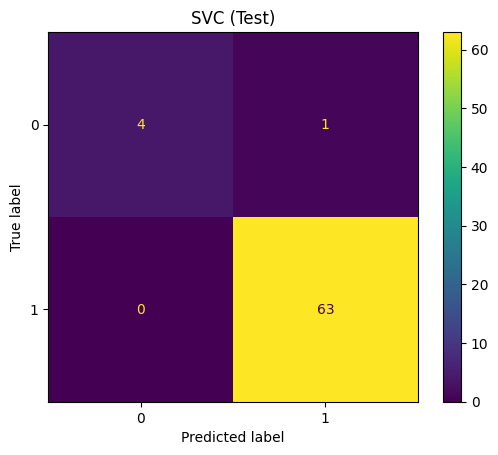

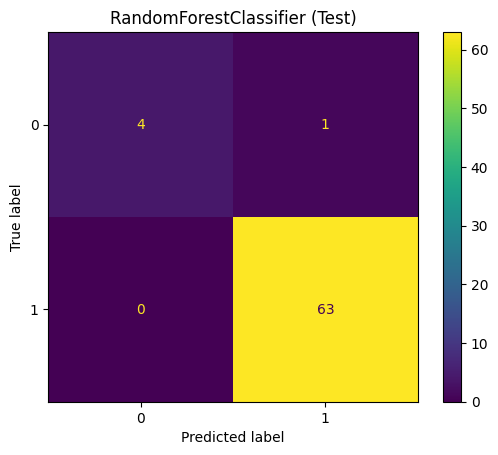

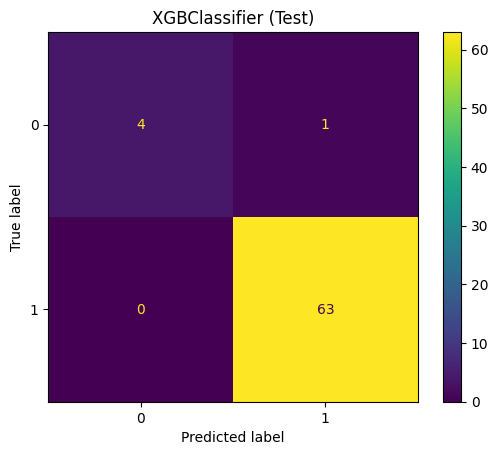

In [16]:
for estim in anova_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, anova_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

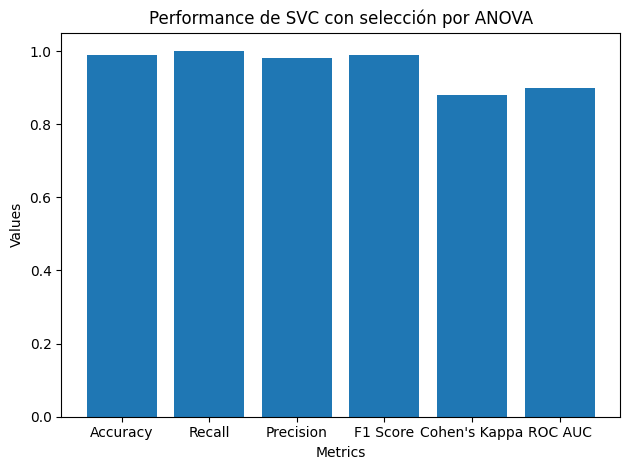

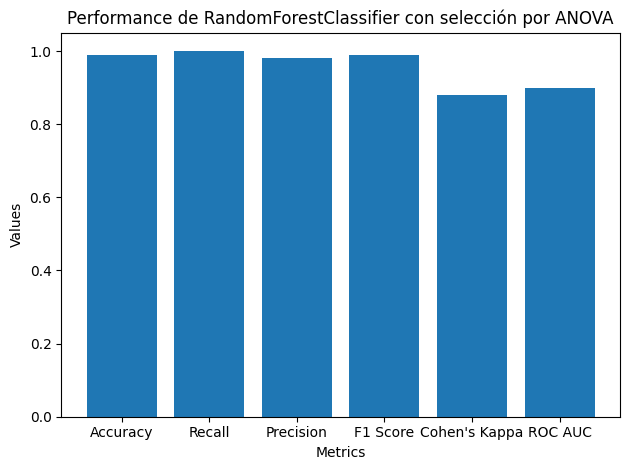

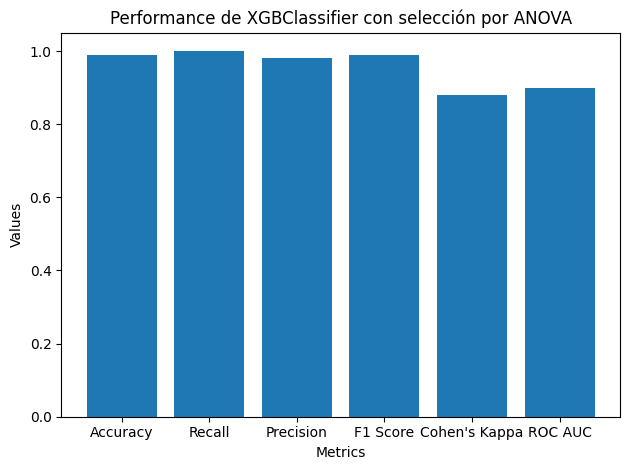

In [17]:
for estim in anova_pred_test:
    bar_metrics(y_test, anova_pred_test[estim], f"Performance de {estim} con selección por ANOVA")

### Selección con SVM

In [18]:
svm_pipe = fs_pipeline(sv_fs)
svm_pipe.set_output(transform="pandas")
x_svm = svm_pipe.fit_transform(x_train, y_train)
svm_test = svm_pipe.transform(x_test)

x_svm, y_svm = SMOTE().fit_resample(x_svm, y_train)
x_svm.shape

(498, 5122)

In [19]:
svm_estimators = fit_estimators_from_dict(x_svm, y_svm, basic_estimators)

In [20]:
svm_pred_test = predict_from_dict(svm_test, svm_estimators)

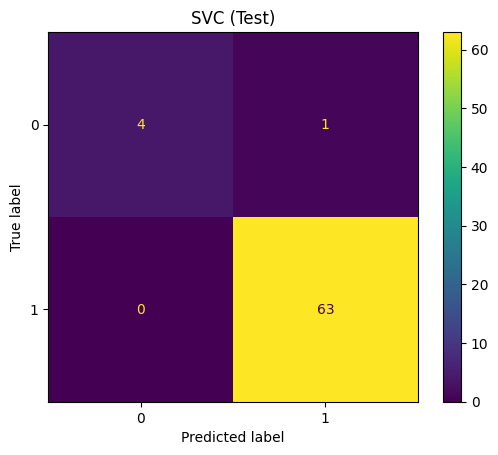

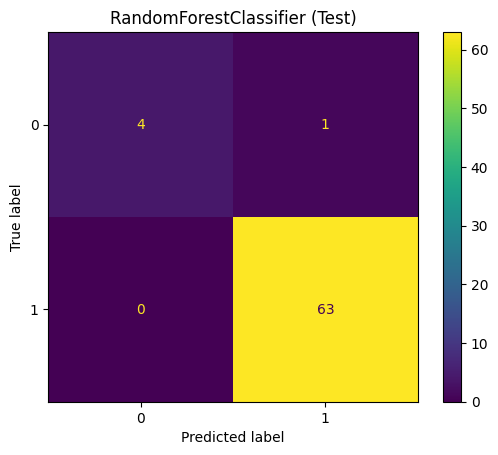

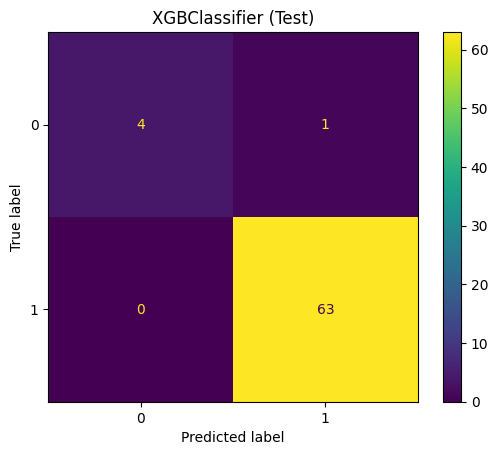

In [21]:
for estim in svm_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, svm_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

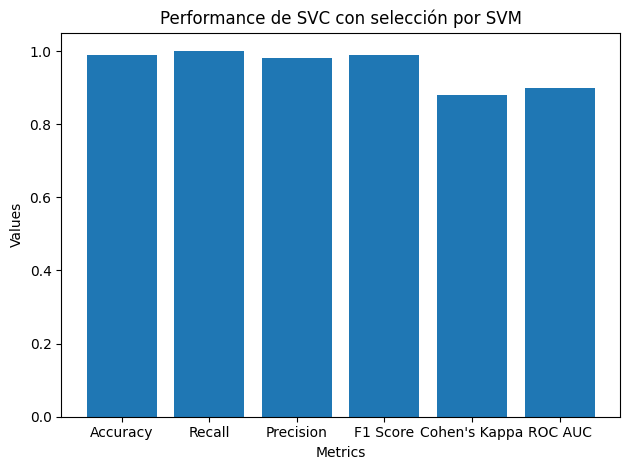

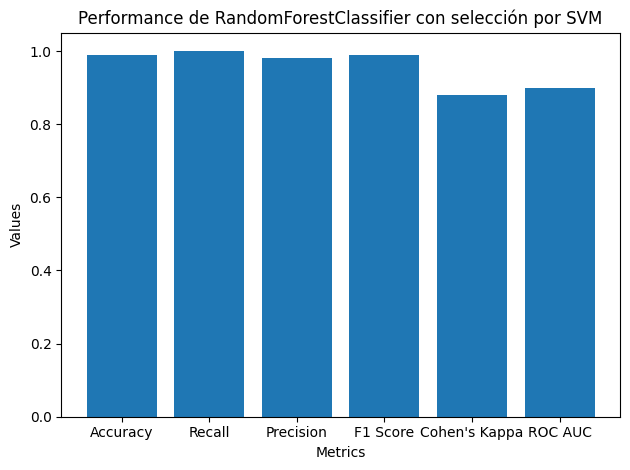

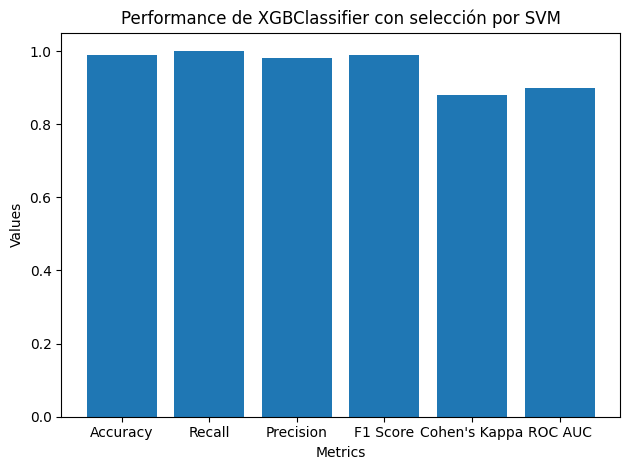

In [22]:
for estim in svm_pred_test:
    bar_metrics(y_test, svm_pred_test[estim], f"Performance de {estim} con selección por SVM")

### Selección con Random Forest iterativo

In [23]:
rf_pipe = fs_pipeline(iter_rf_fs)
rf_pipe.set_output(transform="pandas")
x_rf = rf_pipe.fit_transform(x_train, y_train)
rf_test = rf_pipe.transform(x_test)

x_rf, y_rf = SMOTE().fit_resample(x_rf, y_train)
x_rf.shape

In [ ]:
rf_estimators = fit_estimators_from_dict(x_rf, y_rf, basic_estimators)

In [ ]:
rf_pred_test = predict_from_dict(rf_test, rf_estimators)

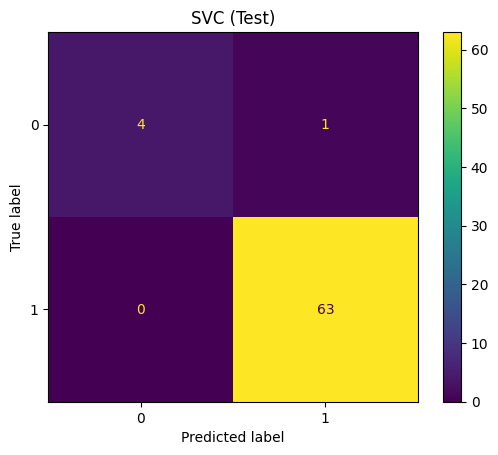

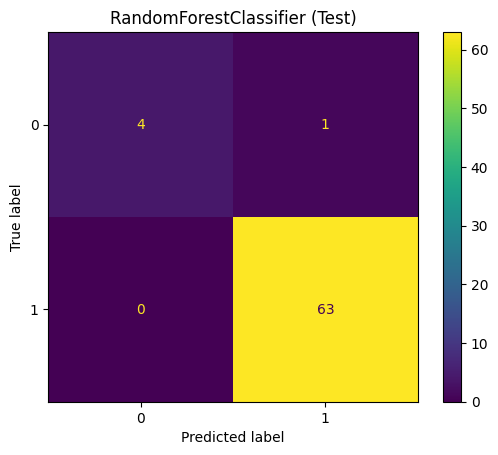

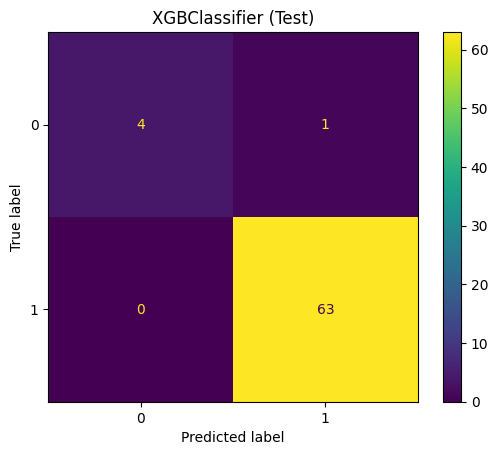

In [ ]:
for estim in rf_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

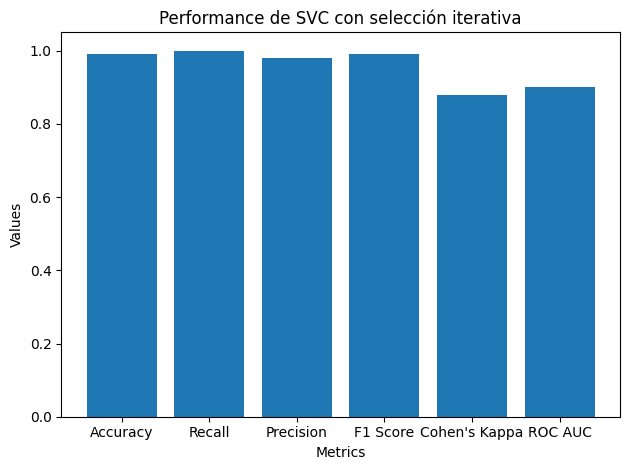

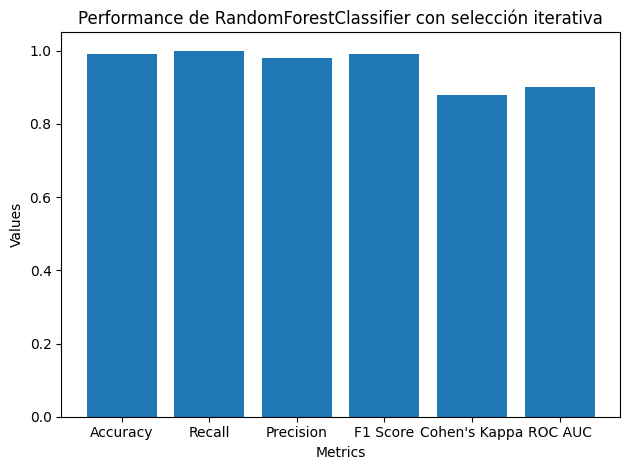

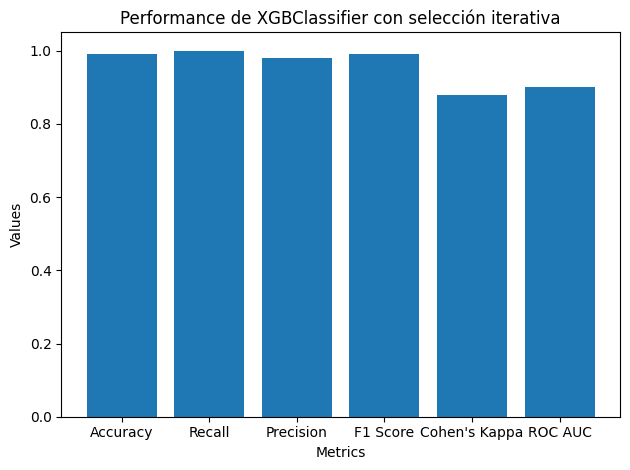

In [ ]:
for estim in rf_pred_test:
    bar_metrics(y_test, rf_pred_test[estim], f"Performance de {estim} con selección iterativa")

## Interpretabilidad